In [1]:
import pandas as pd
import numpy as np
import utilities.misc as um
import utilities.constants as uc
import pdb
from blp.bdx import bdh,bdp,bds
from fql.fql import Factset_Query
from fql.util import bbg_to_fs, fs_to_bbg,fql_date
from blp.util import get_bbg_usual_col, group_marcap,get_ashare_exchange,load_compo
import feather
import os

#plotly related
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import utilities.display as ud

from datetime import datetime

import utilities.mathematics as umath

from joblib import load, dump

import matplotlib.pyplot as plt


In [2]:
path=uc.root_path_data+'connect\\ccass\\'

universe=pd.read_excel(path+'universe.xlsx',sheet_name='quick_tagging_load').set_index('ticker')
cut_off_adv=5

impact_cutoff=0.5

In [3]:
# # collect and dump raw data
# path_raw_data=path+'data_raw\\'
# all_files=um.iterate_csv(path_raw_data,iterate_others=[True,'.feather'])
# collector=[]
# for data_i in all_files:
#     collector.append(feather.read_dataframe(path_raw_data+'%s.feather' % (data_i)))
# data_raw=pd.concat(collector)
# feather.write_dataframe(data_raw,path+'data_raw.feather')

In [4]:
# # load raw data, tidy up and dump
# data_raw=feather.read_dataframe(path+'data_raw.feather')
# data_raw=data_raw[(data_raw['holding']!=0) & (data_raw['date']>=datetime(2010,1,1))].copy()
# data_raw=data_raw.groupby(['date','ticker'])['holding'].last().reset_index()
# data_raw=data_raw.set_index('ticker').join(universe).dropna()
# data_raw=data_raw[data_raw['average_adv']>=cut_off_adv].reset_index().copy()
# feather.write_dataframe(data_raw,path+'data_raw_clean.feather')

In [5]:
# # load and dump market data
# data_raw_tidy=feather.read_dataframe(path+'data_raw_clean.feather')
# start_date=data_raw_tidy['date'].min()
# end_date=data_raw_tidy['date'].max()
# tickers=data_raw_tidy.groupby('ticker').last().index.tolist()
# fields_adj=['PX_LAST','EQY_WEIGHTED_AVG_PX','CUR_MKT_CAP','TURNOVER']
# fields_unadj=['EQY_WEIGHTED_AVG_PX']

# mkt_data_adj=bdh(tickers,fields_adj,start_date,end_date)
# mkt_data_unadj=bdh(tickers,fields_unadj,start_date,end_date,adjustmentFollowDPDF='No')

# feather.write_dataframe(mkt_data_adj.reset_index(),path+'mkt_data_adj.feather')
# feather.write_dataframe(mkt_data_unadj.reset_index(),path+'mkt_data_unadj.feather')

# hsi=bdh(['HSI Index'],['TURNOVER'],datetime(2010,1,1),um.today_date()).reset_index()
# feather.write_dataframe(hsi,path+'hsi_dates.feather')

In [9]:
# calculate a few stats: $flow, flow consistency, holdings vs. marcap, flow vs. Turnover; 
# across 1-12 week
# future stock return (raw)
# use data from 3 days ago

# combine mkt data and raw_data
data_raw_tidy=feather.read_dataframe(path+'data_raw_clean.feather')
mkt_data_adj=feather.read_dataframe(path+'mkt_data_adj.feather')
mkt_data_unadj=feather.read_dataframe(path+'mkt_data_unadj.feather')
hsi_dates=feather.read_dataframe(path+'mkt_data_unadj.feather').groupby('date').last().index


holding_shares_raw=data_raw_tidy.set_index(['date','ticker'])['holding'].unstack().reindex(hsi_dates).fillna(method='ffill').shift(-2).fillna(method='ffill').fillna(0)
flow_shares_raw=holding_shares_raw.diff().fillna(0)

vwap_unadj=mkt_data_unadj.set_index(['date','ticker'])['EQY_WEIGHTED_AVG_PX'].unstack().reindex(flow_shares_raw.index,axis=0).reindex(flow_shares_raw.columns,axis=1)
flow_hkd_raw=flow_shares_raw.multiply(vwap_unadj) # unit 1
holding_hkd_raw=holding_shares_raw.multiply(vwap_unadj) # unit 1
turnover=mkt_data_adj.set_index(['date','ticker'])['TURNOVER'].unstack().reindex(flow_shares_raw.index,axis=0).reindex(flow_shares_raw.columns,axis=1) # unit 1

impact_mask=flow_hkd_raw.divide(turnover).abs().applymap(lambda x: True if x>=impact_cutoff else False)
holding_shares_raw_mask=holding_shares_raw.applymap(lambda x: True if x==0 else False)

flow_hkd=flow_hkd_raw.mask(impact_mask).mask(holding_shares_raw_mask) # if nan then not traded yet or invalid data point, if 0 then no flow
holding_hkd=holding_hkd_raw.mask(impact_mask).mask(holding_shares_raw_mask).fillna(method='ffill') # not a clean way to ffill, should do shares and multiply unadj last price, just do this for now

marcap=mkt_data_adj.set_index(['date','ticker'])['CUR_MKT_CAP'].unstack().reindex(flow_hkd.index,axis=0).reindex(flow_hkd.columns,axis=1)*1000000 # unit 1
turnover=mkt_data_adj.set_index(['date','ticker'])['TURNOVER'].unstack().reindex(flow_hkd.index,axis=0).reindex(flow_hkd.columns,axis=1)
px_last=mkt_data_adj.set_index(['date','ticker'])['PX_LAST'].unstack().reindex(flow_hkd.index,axis=0).reindex(flow_hkd.columns,axis=1)

windows=[5,10,15,20,25,30,35,40,45,50,55,60] # 1w to 3month
collector=[]
for i,window in enumerate(windows):
    print ('working on %s' % (window))
    ret_fwd=px_last.pct_change(window).shift(-window)
    flow=flow_hkd.rolling(window,min_periods=3).sum()
    flow_consistency=flow_hkd.applymap(lambda x: 0 if x<=0 else 1).rolling(window).sum()/window
    impact_turnover=(flow_hkd.divide(turnover)).rolling(window,min_periods=3).mean()
    stake_marcap=(holding_hkd.divide(marcap))
    flow_x_consistency=flow.multiply(flow_consistency)
    
    if i==0:
        to_fit_i=(ret_fwd.stack().rename('ret_%s' % (window)).to_frame()
            .join(flow.shift(3).stack().rename('flow_%s'% (window)))
            .join(flow_consistency.shift(3).stack().rename('consistency_%s'% (window)))
            .join(impact_turnover.shift(3).stack().rename('impact_turnover_%s'% (window)))
            .join(flow_x_consistency.shift(3).stack().rename('flow_x_consistency_%s'% (window)))
            # only calculate stake one time
            .join(stake_marcap.shift(3).stack().rename('stake_marcap'))
        )
    else:
        to_fit_i=(ret_fwd.stack().rename('ret_%s' % (window)).to_frame()
            .join(flow.shift(3).stack().rename('flow_%s'% (window)))
            .join(flow_consistency.shift(3).stack().rename('consistency_%s'% (window)))
            .join(impact_turnover.shift(3).stack().rename('impact_turnover_%s'% (window)))
            .join(flow_x_consistency.shift(3).stack().rename('flow_x_consistency_%s'% (window)))
            # only calculate stake one time
            # .join(stake_marcap.shift(3).stack().rename('stake_marcap'))
        )
    
    collector.append(to_fit_i)
    
to_fit_all=pd.concat(collector,axis=1)

feather.write_dataframe(to_fit_all.reset_index(),path+'to_fit_all.feather')

working on 5
working on 10
working on 15
working on 20
working on 25
working on 30
working on 35
working on 40
working on 45
working on 50
working on 55
working on 60


In [7]:
# # can't do sector neutral ranking, too few names, you can do sector neutral portfolio later
# to_fit_i.reset_index().set_index('ticker').join(universe['sector']).reset_index().groupby(['date','sector']).count()['ticker'].unstack()

In [10]:
# get the datablock that can be fed into the model
to_fit_all=feather.read_dataframe(path+'to_fit_all.feather')
to_fit_all_rank=to_fit_all.groupby('date').rank(pct=True,ascending=True,method='min')
to_fit_all_rank.columns=to_fit_all_rank.columns.map(lambda x: x+'_rank')
to_fit_tidyup=pd.concat([to_fit_all[['date','ticker','stake_marcap']+['consistency_%s' % (x) for x in windows]],
           to_fit_all_rank
          ],axis=1)
feather.write_dataframe(to_fit_tidyup,path+'to_fit_tidyup.feather')

In [ ]:
skip below

In [9]:
# # run the machine learning
# to_fit_tidyup=feather.read_dataframe(path+'to_fit_tidyup.feather') # just dropna for quick dirty results
# data_loss=len(to_fit_tidyup.dropna())/len(to_fit_tidyup)
# print ('data loss after dropna %s' % (1-data_loss))
# to_fit_tidyup=to_fit_tidyup.dropna()

data loss after dropna 0.05083067308816025


In [63]:
# # iterate through window and run fitting

# windows=[5,10,15,20,25,30,35,40,45,50,55,60]


# for window_y in windows:
#     y='ret_%s_rank' % (window_y)
#     xs=(['stake_marcap']
#         +['consistency_%s' % (x) for x in windows]
#         +['consistency_%s_rank' % (x) for x in windows] 
#         +['flow_%s_rank' % (x) for x in windows] 
#         +['impact_turnover_%s_rank' % (x) for x in windows] 
#     )  

#     to_fit_i=to_fit_tidyup[[y]+xs]


#     ebm=umath.get_ebm_initialized()
#     model_i=ebm.fit(to_fit_i[xs],to_fit_i[y])


#     dump(model_i,path+'models_full_data\\%s.joblib' % (window_y))
    
#     print ('model %s dumped' % (window_y))

finished dumping 5
finished dumping 10
finished dumping 15
finished dumping 20
finished dumping 25
finished dumping 30
finished dumping 35
finished dumping 40
finished dumping 45
finished dumping 50
finished dumping 55
finished dumping 60


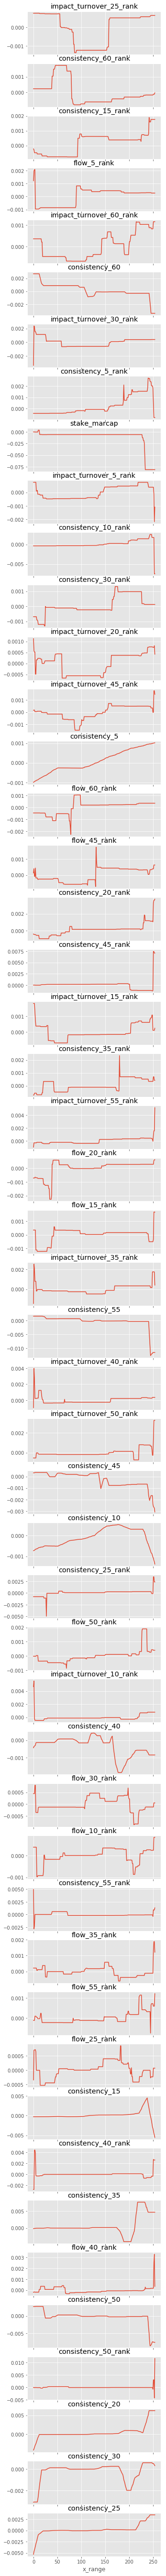

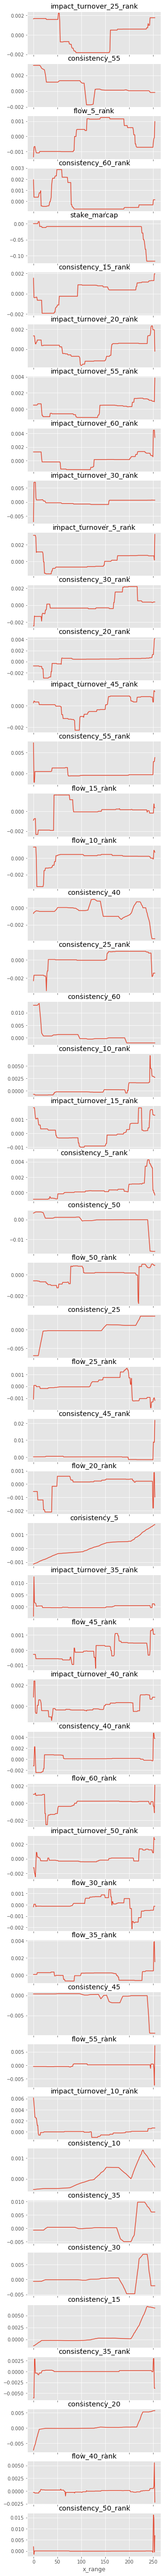

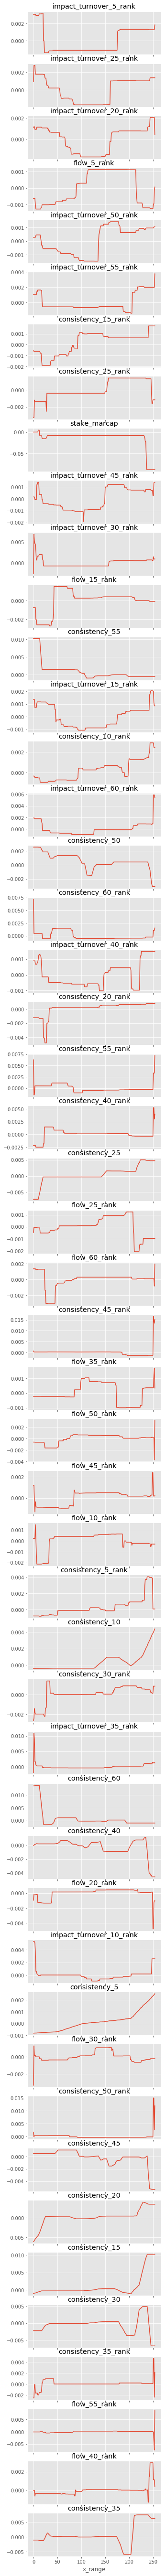

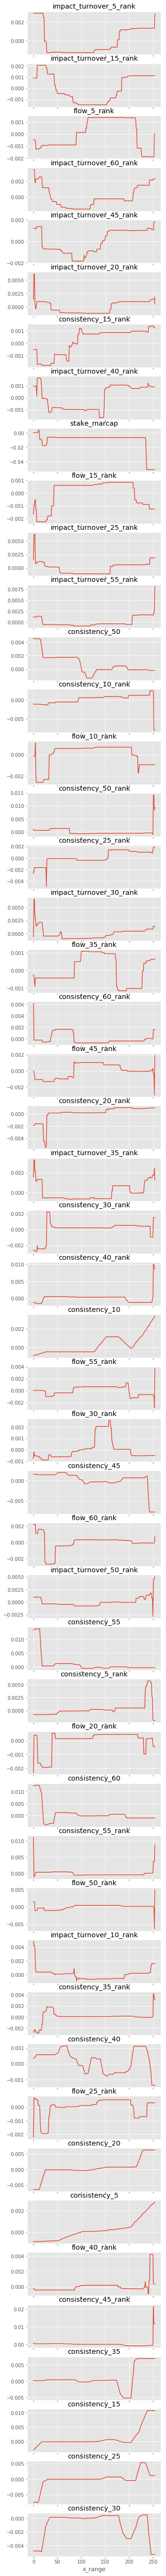

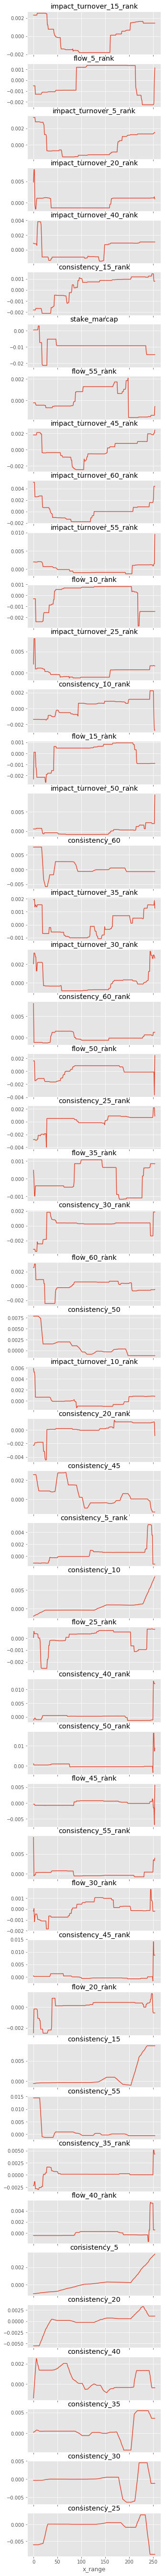

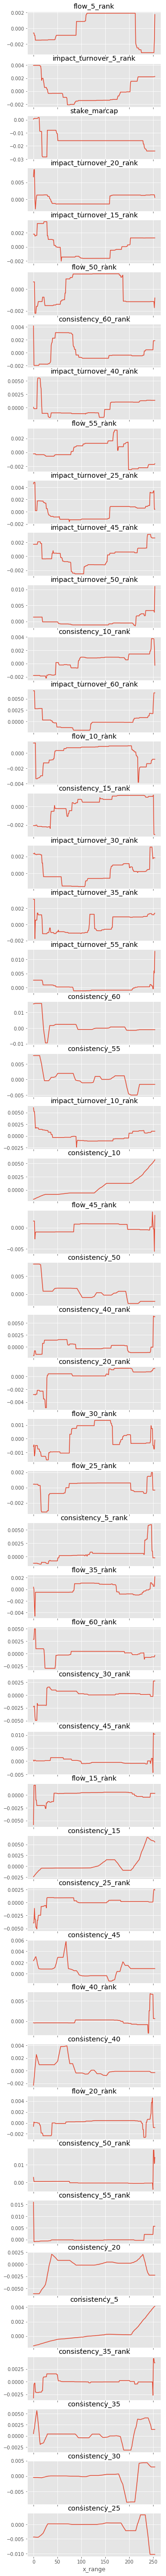

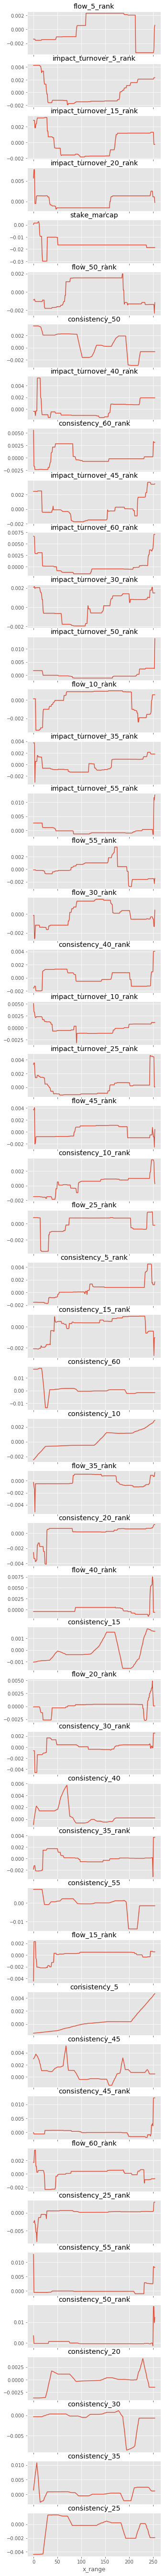

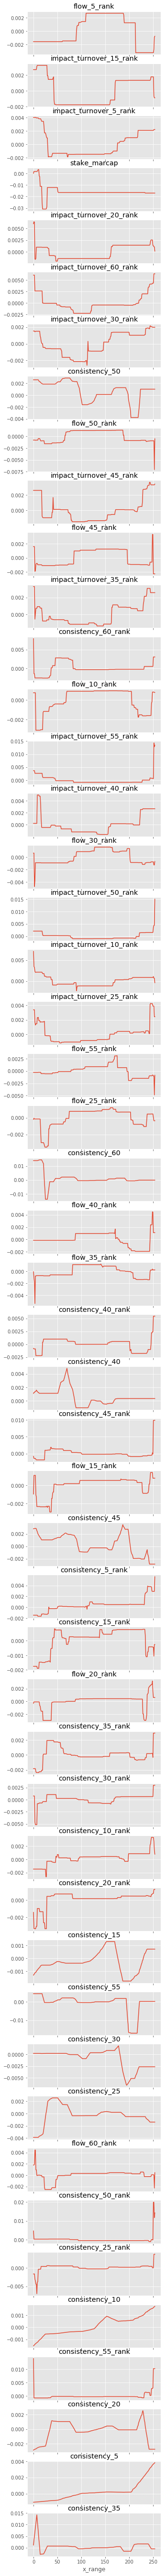

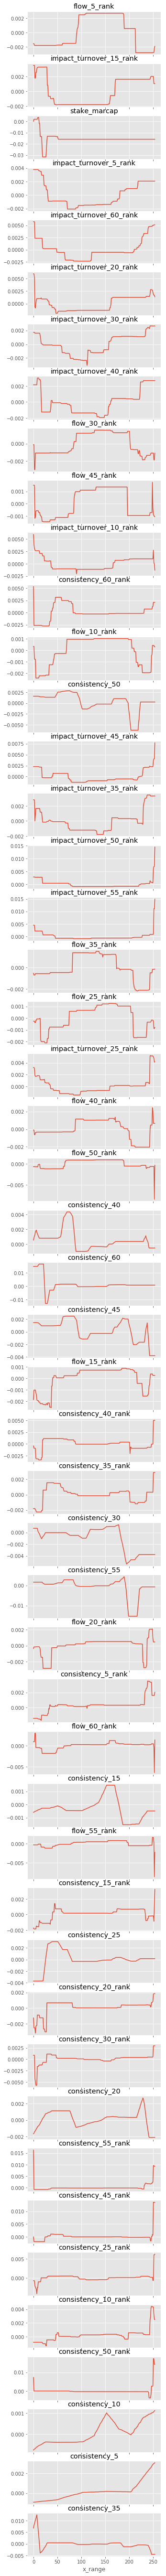

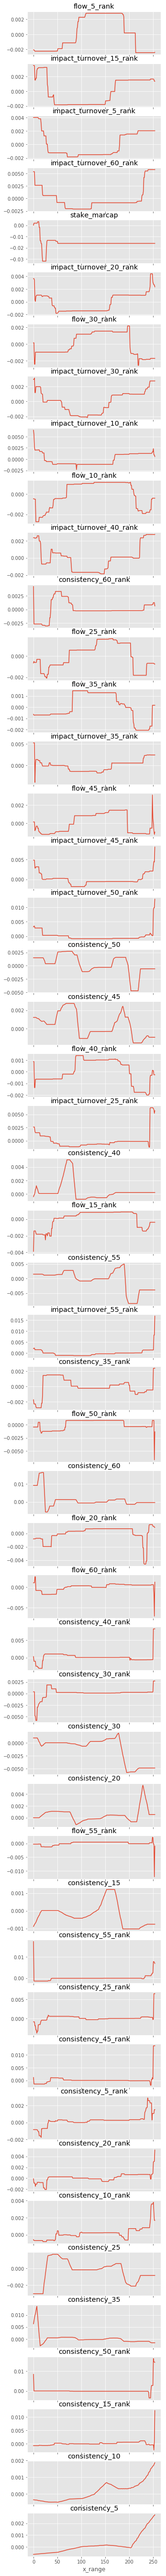

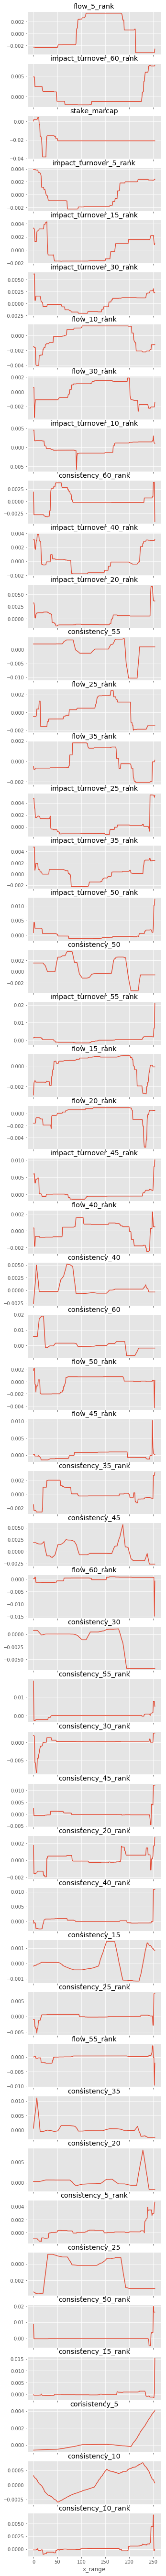

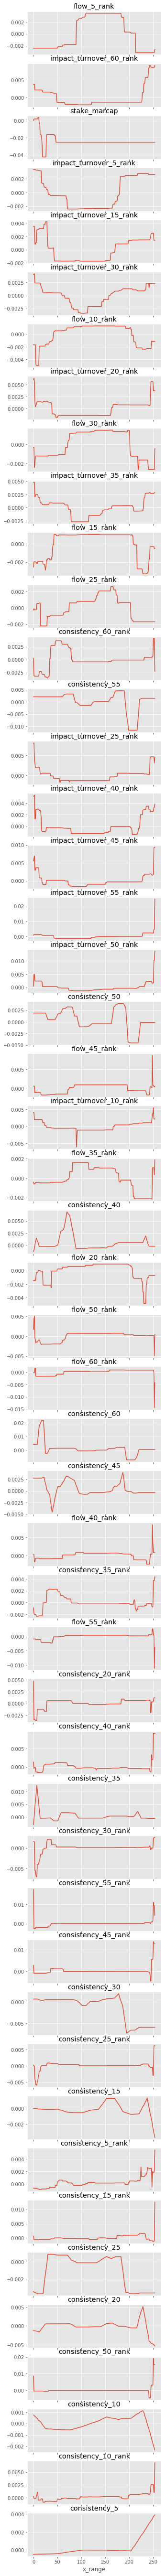

In [67]:
# windows=[5,10,15,20,25,30,35,40,45,50,55,60]

# for window in windows:
#     model_i=load(path+'models_full_data\\%s.joblib' % (window))
    
#     coefs, shapes=umath.get_ebm_coef_rank_and_shape(model_i)
    
#     coefs_nice=coefs['importance'].sort_values(ascending=False)
#     fig,axes=plt.subplots(len(coefs_nice.index),1,figsize=(5,2*len(coefs_nice.index)),sharex=True)
    
#     for i,predictor_i in enumerate(coefs_nice.index):
#         shapes[shapes['predictor']==predictor_i]['shape'].plot(ax=axes[i],title=predictor_i)
    
#     fig.savefig(path+'models_full_data\\%s.png' % (window),bbox_inches='tight',dpi=200)
#     print ('finished dumping %s' % (window))